In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [31]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [50]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [51]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [52]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())


      0/ 200000: 3.3292
  10000/ 200000: 2.1630
  20000/ 200000: 2.2205
  30000/ 200000: 1.9733
  40000/ 200000: 2.2263
  50000/ 200000: 1.9678
  60000/ 200000: 2.2090
  70000/ 200000: 2.0360
  80000/ 200000: 2.0203
  90000/ 200000: 1.8599
 100000/ 200000: 2.3646
 110000/ 200000: 2.0548
 120000/ 200000: 2.0397
 130000/ 200000: 2.2740
 140000/ 200000: 1.9553
 150000/ 200000: 2.0562
 160000/ 200000: 1.9051
 170000/ 200000: 2.0793
 180000/ 200000: 1.9072
 190000/ 200000: 2.0141


In [45]:
# Loss log

# original:
train 2.1210389137268066
val 2.1784117221832275

# fix softmax confidently wrong:
# 通过把 logits 控制在 close to 0; 即通过 W2*0.01 以及 b2*0
train 2.067570209503174
val 2.1371042728424072

# fix tanh layer too satureated at init
train 2.0364649295806885
val 2.103123903274536

SyntaxError: invalid syntax (3615858869.py, line 4)

(array([  7.,  12.,  27.,  31.,  46.,  63.,  76.,  89., 100., 106., 125.,
        137., 162., 145., 161., 158., 172., 174., 167., 198., 176., 187.,
        201., 197., 195., 205., 187., 194., 205., 190., 180., 199., 159.,
        190., 155., 166., 176., 140., 154., 118., 121., 116., 112.,  91.,
         91.,  54.,  39.,  23.,  19.,   4.]),
 array([-0.96543849, -0.92657177, -0.88770505, -0.84883833, -0.80997161,
        -0.77110489, -0.73223817, -0.69337145, -0.65450473, -0.61563801,
        -0.5767713 , -0.53790458, -0.49903786, -0.46017114, -0.42130442,
        -0.3824377 , -0.34357098, -0.30470426, -0.26583754, -0.22697082,
        -0.1881041 , -0.14923739, -0.11037067, -0.07150395, -0.03263723,
         0.00622949,  0.04509621,  0.08396293,  0.12282965,  0.16169637,
         0.20056309,  0.2394298 ,  0.27829652,  0.31716324,  0.35602996,
         0.39489668,  0.4337634 ,  0.47263012,  0.51149684,  0.55036356,
         0.58923028,  0.62809699,  0.66696371,  0.70583043,  0.74469715,
 

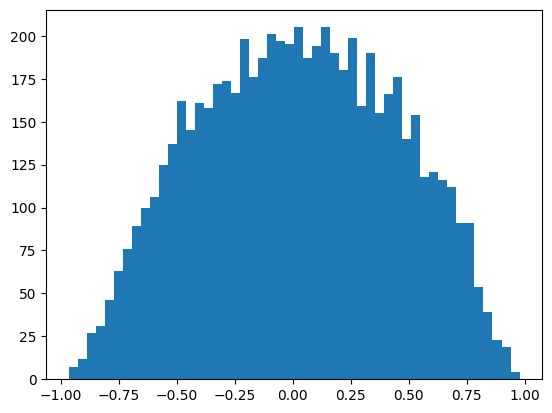

In [46]:
plt.hist(h.view(-1).tolist(), 50)

(array([  3.,   0.,   3.,   0.,   1.,   3.,   6.,  17.,  13.,  18.,  34.,
         40.,  68.,  94., 114., 150., 190., 275., 277., 315., 349., 395.,
        419., 456., 395., 445., 384., 344., 304., 277., 234., 167., 166.,
        125.,  94.,  84.,  47.,  21.,  28.,  17.,   5.,   7.,   5.,   7.,
          3.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.02036476, -1.9350165 , -1.84966825, -1.76431999, -1.67897173,
        -1.59362347, -1.50827521, -1.42292696, -1.3375787 , -1.25223044,
        -1.16688218, -1.08153392, -0.99618567, -0.91083741, -0.82548915,
        -0.74014089, -0.65479263, -0.56944438, -0.48409612, -0.39874786,
        -0.3133996 , -0.22805134, -0.14270308, -0.05735483,  0.02799343,
         0.11334169,  0.19868995,  0.28403821,  0.36938646,  0.45473472,
         0.54008298,  0.62543124,  0.7107795 ,  0.79612775,  0.88147601,
         0.96682427,  1.05217253,  1.13752079,  1.22286904,  1.3082173 ,
         1.39356556,  1.47891382,  1.56426208,  1.64961033,  1.73495859,
 

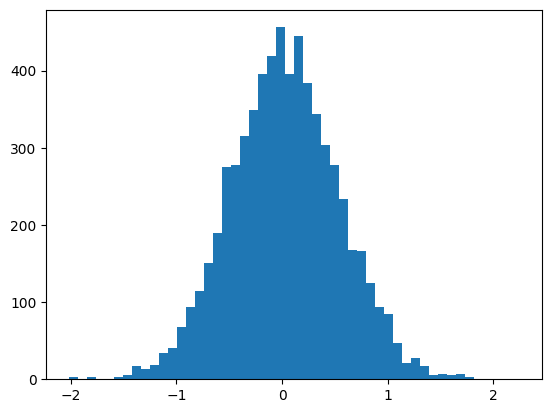

In [47]:
plt.hist(hpreact.view(-1).tolist(), 50)

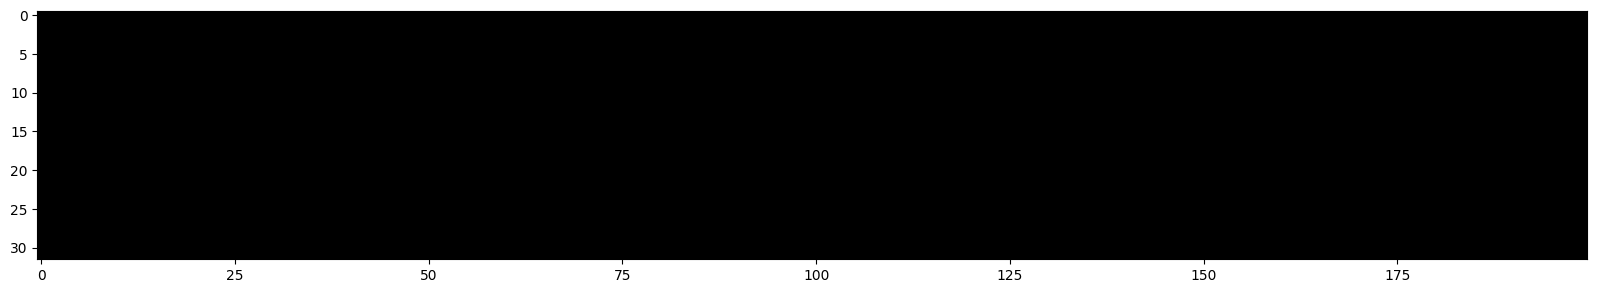

In [48]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# True 显示为 白色
# False 显示为 黑色

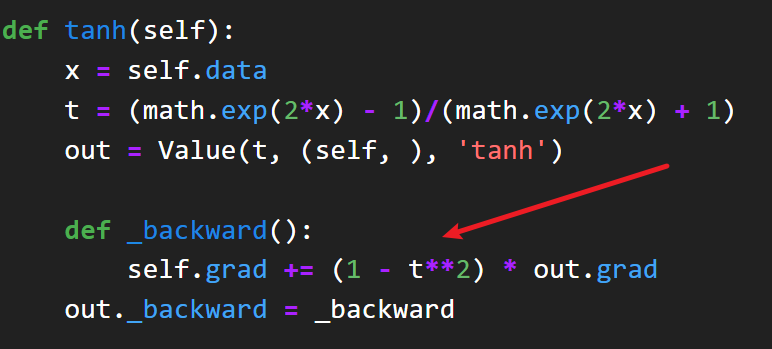

In [ ]:
# 如果这里 hidden layer 200 个 neuron，如果某一列都为白色，表示所有的 X 在 hpreact 都落在了 tanh 的 flat region
# 在这种情况下，这个 init weights/bias 的 neuron 永远无法学习，因为 grad = 0，会 vanish

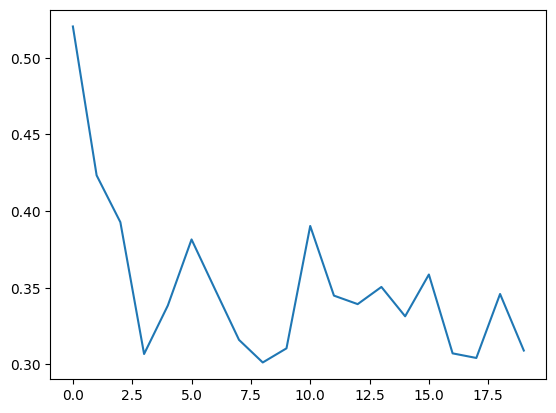

In [19]:
plt.plot(lossi)

In [53]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0364649295806885
val 2.103123903274536


在计算交叉熵损失时，通常我们只关注真实标签对应的概率，而不是将所有的概率都加起来。这是因为交叉熵损失的目标是衡量模型在真实标签上的预测概率。

具体来说，交叉熵损失的公式是：
\[ \text{CrossEntropyLoss} = -\sum_{i} y_i \log(\hat{y}_i) \]

其中：
- \( y_i \) 是真实标签的分布（通常是one-hot编码）。
- \( \hat{y}_i \) 是预测的概率分布。

对于单个样本，假设真实标签是第 \( j \) 类（即 \( y_j = 1 \)），那么交叉熵损失可以简化为：
\[ \text{CrossEntropyLoss} = -\log(\hat{y}_j) \]

这是因为one-hot编码的真实标签向量中，只有一个元素为1，其余元素为0。因此，只有真实标签对应的概率会对损失值产生贡献，其余概率的对数来说，交叉熵损失只关注真实标签对应的概率的对数值，因为这反映了模型在真实标签上的预测准确性。其他类别的概率对当前样本的损失没有直接影响。来说，交叉熵损失只关注真实标签对应的概率的对数值，因为这反映了模型在真实标签上的预测准确性。其他类别的概率对当前样本的损失没有直接影响。

In [10]:
# 4-dimensional example of the issue
# 这里假设 character 的数量为 4，最终输出的 logits 数量为 4
logits = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]), tensor(1.6094))